In [ ]:
# Financial inclusion project
# Name: Immanuella Duke
# Description: This project predicts whether a given person has a bank account or not.
# Link to hackathon: https://zindi.africa/competitions/financial-inclusion-in-africa


## Import libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration stage

In [101]:
# import the training data
train_data = pd.read_csv("Train_v2.csv")
#test x
test_X = pd.read_csv("Test_v2.csv")


### Encode column items

In [36]:
train_X.head(1)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed


In [46]:
train_X['job_type'].value_counts()

Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        627
Formally employed Government     387
Government Dependent             247
Dont Know/Refuse to answer       126
Name: job_type, dtype: int64

In [102]:
# check for correlations in the Data

# encode categorical variables

clean_upX = {'country': {'Rwanda':0, 'Tanzania': 1, 'Kenya':2, 'Uganda': 3},
'location_type': {'Rural':0, 'Urban': 1},
'cellphone_access': {'Yes': 0, 'No': 1},
'gender_of_respondent': {'Female': 0, 'Male': 1},
'relationship_with_head': {'Head of Household': 0, 'Spouse': 1, 'Child': 2, 'Parent': 3, 'Other relative': 4, 'Other non-relatives': 5},
'marital_status': {'Married/Living together': 0, 'Single/Never Married': 1, 'Widowed': 2, 'Divorced/Seperated': 3, 'Dont know': 4},
'education_level': {'Primary education': 0, 'No formal education': 1, 'Secondary education': 2, 
                    'Tertiary education': 3, 'Vocational/Specialised training':4,'Other/Dont know/RTA': 5 },
'job_type': {'Self employed': 0, 'Informally employed': 1, 'Farming and Fishing': 2, 'Remittance Dependent':3, 'Other Income':4,
                     'Formally employed Private': 5, 'No Income': 6, 'Formally employed Government': 7, 'Government Dependent': 8, 'Dont Know/Refuse to answer': 9 },
                     'bank_account': {'Yes': 0, 'No': 1}
}

# replace columns
train_data.replace(clean_upX, inplace=True)

In [103]:
# training y
train_Y = train_data['bank_account']
train_Y

0        0
1        1
2        0
3        1
4        1
        ..
23519    1
23520    1
23521    1
23522    1
23523    1
Name: bank_account, Length: 23524, dtype: int64

In [104]:
#training x
train_X = train_data[['country','year', 'uniqueid','location_type', 'cellphone_access', 'household_size',
                    'age_of_respondent' ,'gender_of_respondent', 'relationship_with_head', 'marital_status', 
                    'education_level', 'job_type']]
train_X

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,2,2018,uniqueid_1,0,0,3,24,0,1,0,2,0
1,2,2018,uniqueid_2,0,1,5,70,0,0,2,1,8
2,2,2018,uniqueid_3,1,0,5,26,1,4,1,4,0
3,2,2018,uniqueid_4,0,0,5,34,0,0,0,0,5
4,2,2018,uniqueid_5,1,1,8,26,1,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23519,3,2018,uniqueid_2113,0,0,4,48,0,0,3,1,4
23520,3,2018,uniqueid_2114,0,0,2,27,0,0,1,2,4
23521,3,2018,uniqueid_2115,0,0,5,27,0,3,2,0,4
23522,3,2018,uniqueid_2116,1,0,7,30,0,3,3,2,0


In [114]:
train_X.isnull().values.any()

False

([<matplotlib.axis.YTick at 0x1b8f6537f08>,
 <a list of 12 Text yticklabel objects>)

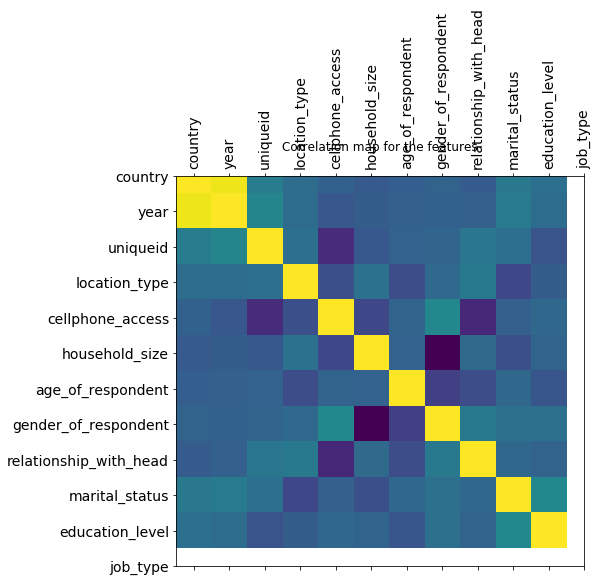

In [124]:
## correlations
train_X.corr()

#heap map of the correlations
f = plt.figure(figsize=(10,7))
plt.matshow(train_X.corr(), fignum= f.number)
plt.title("Correlation map for the features")
plt.xticks(range(train_X.shape[1]), train_X.columns, fontsize=14, rotation=90)
plt.yticks(range(train_X.shape[1]), train_X.columns, fontsize=14)

#### we see a weak positive correlation between education level and a person's country, 
#### location_type and marital status also have a weak positive correlation
#### education level, marital statusage, gender of respondent have weak correlations in the range of 0.1 with cell phone access
#### household size and relationship with head of the household have 0.2 correlation
#### the older the respondent the less of a relationship they have with the head - perhaps children are closer to their parents?
#### 